<a href="https://colab.research.google.com/github/nabarahim/RA_ECG-Anamolies-Project-FRGS-Fall-2021/blob/main/ECG_(Customized_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%config IPCompleter.greedy=True

In [ ]:
df_mitbih_ptbdb_train = pd.read_csv('/content/drive/MyDrive/ECG/mitbih+ptbdb train.csv', header=None)
df_mitbih_ptbdb_test = pd.read_csv('/content/drive/MyDrive/ECG/mitbih+ptbdb test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_ptbdb_train, df_mitbih_ptbdb_test], axis=0)


print(df_mitbih.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB
None


In [ ]:
# mitbih+ptbdb
M_mitbih = df_mitbih.values
X_mitbih = M_mitbih[:,:-1]
y_mitbih = M_mitbih[:,-1]

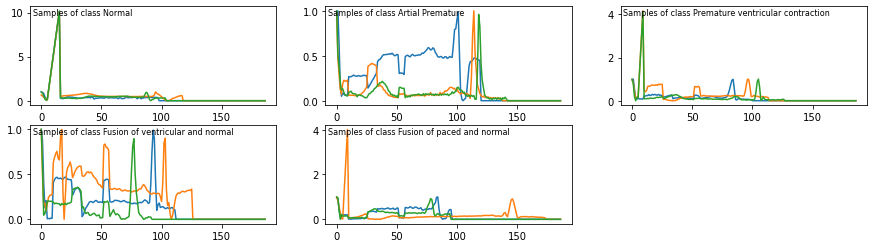

In [ ]:
classes={0:"Normal",
         1:"Artial Premature",
         2:"Premature ventricular contraction",
         3:"Fusion of ventricular and normal",
         4:"Fusion of paced and normal"}
plt.figure(figsize=(15,4))
for i in range(0,5):
    plt.subplot(2,3,i + 1)
    all_samples_indexes = np.where(y_mitbih == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_mitbih[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc='left', fontdict={'fontsize':8}, x=0.01, y=0.85)

In [ ]:
repartition = df_mitbih[187].astype(int).value_counts()
print(repartition)

0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64


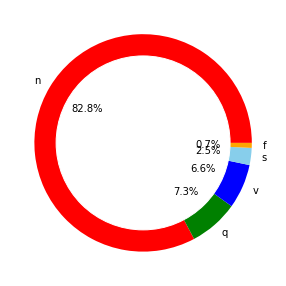

In [ ]:
plt.figure(figsize=(5,5))
circle=plt.Circle( (0,0), 0.8, color='white')
plt.pie(repartition, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
input_shape = (187, 1)

def make_model(final_layer_size=5):
    I = Input(input_shape)
    C = Conv1D(filters=32, kernel_size=5)(I)

    C11 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(C)
    C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
    A11 = Add()([C, C12])
    R11 = Activation(activation='swish')(A11)
    M11 = MaxPool1D(pool_size=5, strides=2)(R11)

    C21 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M11)
    C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
    A21 = Add()([M11, C22])
    R21 = Activation(activation='swish')(A21)
    M21 = MaxPool1D(pool_size=5, strides=2)(R21)

    C31 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M21)
    C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
    A31 = Add()([M21, C32])
    R31 = Activation(activation='swish')(A31)
    M31 = MaxPool1D(pool_size=5, strides=2)(R31)

    C41 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M31)
    C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
    A41 = Add()([M31, C42])
    R41 = Activation(activation='swish')(A41)
    M41 = MaxPool1D(pool_size=5, strides=2)(R41)

    C51 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M41)
    C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
    A51 = Add()([M41, C52])
    R51 = Activation(activation='swish')(A51)
    M51 = MaxPool1D(pool_size=5, strides=2)(R51)

    F1 = Flatten()(M51)
    D1 = Dense(32)(F1)
    R1 = Activation(activation='swish')(D1)
    D2 = Dense(32)(R1)
    D3 = Dense(final_layer_size)(D2)

    O = Activation(activation='softmax')(D3)

    return Model(inputs=I, outputs=O)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0010, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

NameError: ignored

In [ ]:
##X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(X_ptbdb, y_ptbdb, test_size=0.15)

In [ ]:
def plot_learning(history):
    plt.subplot(211)
    plt.plot(history.history['accuracy'], color = 'g')
    plt.legend(["accuracy"])
    plt.subplot(212)
    plt.plot(history.history['loss'], color = 'r')
    plt.plot(history.history['val_loss'], label = "val_loss" , color ='orange')
    plt.legend(["loss", "val_loss"])
    plt.show()

In [ ]:
X_train_mitbih, X_test_mitbih, y_train_mitbih, y_test_mitbih = train_test_split(X_mitbih, y_mitbih, test_size=0.15)

In [ ]:
n_classes_mitbih = len(np.unique(y_mitbih))
model_mitbih = make_model(n_classes_mitbih)
model_mitbih.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_mitbih.fit(np.expand_dims(X_train_mitbih, axis=2),
                           y_train_mitbih,
                           validation_split=0.15,
                           epochs=15,
                           batch_size=70,
                           verbose=1)

Epoch 1/15
1130/1130 [==============================] - 24s 10ms/step - loss: nan - accuracy: 0.8281 - val_loss: nan - val_accuracy: 0.8252
Epoch 2/15
1130/1130 [==============================] - 8s 7ms/step - loss: nan - accuracy: 0.8287 - val_loss: nan - val_accuracy: 0.8252
Epoch 3/15
1130/1130 [==============================] - 13s 11ms/step - loss: nan - accuracy: 0.8287 - val_loss: nan - val_accuracy: 0.8252
Epoch 4/15
1130/1130 [==============================] - 9s 8ms/step - loss: nan - accuracy: 0.8287 - val_loss: nan - val_accuracy: 0.8252
Epoch 5/15
1130/1130 [==============================] - 8s 7ms/step - loss: nan - accuracy: 0.8287 - val_loss: nan - val_accuracy: 0.8252
Epoch 6/15
1130/1130 [==============================] - 8s 7ms/step - loss: nan - accuracy: 0.8287 - val_loss: nan - val_accuracy: 0.8252
Epoch 7/15
1130/1130 [==============================] - 8s 7ms/step - loss: nan - accuracy: 0.8287 - val_loss: nan - val_accuracy: 0.8252
Epoch 8/15
1130/1130 [========

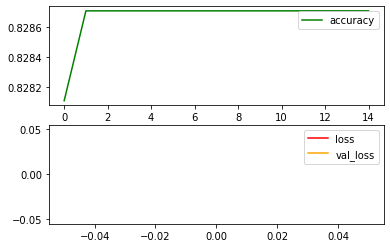

In [ ]:
plot_learning(history)

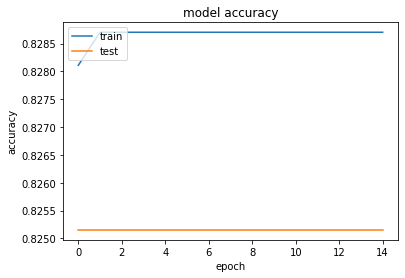

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
initial_learning_rate = 0.01
epochs = 13
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
    history = model.fit(
    X_train,
    y_train,
    epochs=13,
    validation_split=0.15,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],
)

In [ ]:
def plot_lr(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

In [ ]:
#from tensorflow.keras.callbacks import LearningRateScheduler

#initial_learning_rate = 0.01
#epochs = 13
#decay = initial_learning_rate / epochs
#def lr_time_based_decay(epoch, lr):
 #   return lr * 1 / (1 + decay * epoch)

#history_time_based_decay = model_mitbih.fit(
 #   X_train_mitbih,
  #  y_train_mitbih,
   # epochs=40,
    #validation_split=0.15,
    #batch_size=80,
    #callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1,lr)],
#)

In [ ]:
#plt.plot(history_time_based_decay, "accuracy")

In [ ]:
results = model_mitbih.evaluate(np.expand_dims(X_test_mitbih, axis=2), y_test_mitbih, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

129/129 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.8251
The accuracy on the testing set is 82.5%


In [ ]:
predictions = model_mitbih.predict(np.expand_dims(X_test_mitbih, axis=2))
confusion_matrix = tf.math.confusion_matrix(y_test_mitbih, np.argmax(predictions[:], axis=1))
print(confusion_matrix)

tf.Tensor(
[[13545     0     0     0     0]
 [  436     0     0     0     0]
 [ 1057     0     0     0     0]
 [  117     0     0     0     0]
 [ 1262     0     0     0     0]], shape=(5, 5), dtype=int32)


In [ ]:
y_pred_mitbih = model_mitbih.predict(np.expand_dims(X_test_mitbih, axis=2))
y_pred_mitbih_bool = np.argmax(y_pred_mitbih, axis=1)
print(classification_report(y_test_mitbih, y_pred_mitbih_bool))

confusion_matrix = tf.math.confusion_matrix(y_test_mitbih, y_pred_mitbih_bool)
print(f"Confusion matrix :\n {confusion_matrix}")

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.90     13545
         1.0       0.00      0.00      0.00       436
         2.0       0.00      0.00      0.00      1057
         3.0       0.00      0.00      0.00       117
         4.0       0.00      0.00      0.00      1262

    accuracy                           0.83     16417
   macro avg       0.17      0.20      0.18     16417
weighted avg       0.68      0.83      0.75     16417

Confusion matrix :
 [[13545     0     0     0     0]
 [  436     0     0     0     0]
 [ 1057     0     0     0     0]
 [  117     0     0     0     0]
 [ 1262     0     0     0     0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


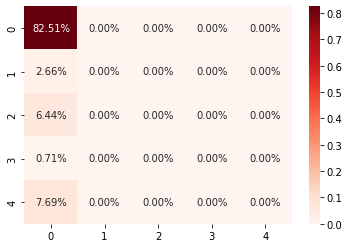

In [ ]:
import seaborn as sns
##sns.heatmap(confusion_matrix, annot=True)

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,
            fmt='.2%', cmap='Reds')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
class LearningRateDecay:
	def plot(self, epochs, title="Learning Rate Schedule"):
		# compute the set of learning rates for each corresponding
		# epoch
		lrs = [self(i) for i in epochs]
		# the learning rate schedule
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(epochs, lrs)
		plt.title(title)
		plt.xlabel("Epoch #")
		plt.ylabel("Learning Rate")

In [ ]:
fig = plt.figure()
plt.plot(range(1,epochs+1),loss_history.lr,label='learning rate')
plt.xlabel("epoch")
plt.xlim([1,epochs+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

In [ ]:
##model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
##param_grid = dict(epochs=[10,20,30])
##grid = GridSearchCV(estimator=model_ptbdb, param_grid=param_grid, n_jobs=-1, cv=3)
##grid_result = grid.fit(X_ptbdb, y_ptbdb)

In [ ]:
##from sklearn.model_selection import GridSearchCV

##search = GridSearchCV(model_mitbih,space, scoring='accuracy', n_jobs=-1, cv=cv)
##result = search.fit(X, y)

In [ ]:
D1 = Dense(32)(model_mitbih.output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)

for layer in model.layers[:-3]:
    layer.trainable = False

for layer in model.layers[-3:]:
    layer.trainable = True

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2),
                    y_train_ptbdb,
                    validation_split=0.15,
                    epochs=5,
                    batch_size=128,
                    verbose=0)

In [ ]:
print("Trainability of the layers \n")
for layer in model.layers:
    config = layer.get_config()
    print(f"{config['name']} : {config.get('trainable')}")

In [ ]:
D1 = Dense(32)(model_mitbih.layers[-3].output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)
model.summary()

In [ ]:
for layer in model.layers[:-3]:
    layer.trainable = False

for layer in model.layers[-3:]:
    layer.trainable = True

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2),
                    y_train_ptbdb,
                    validation_split=0.15,
                    epochs=100,
                    batch_size=128,
                    verbose=0)
plot_learning(history)

**CNN**+**LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, GRU, SimpleRNN, Conv1D, TimeDistributed, MaxPooling1D, Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def init_model():
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'),input_shape))
    model.add(TimeDistributed(MaxPooling1D(pool_size=5)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(16))
    model.add(Dense(9, activation='softmax'))

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
embedding_vecor_length = 187

In [ ]:
model = Sequential()
model.add(Embedding(1000, embedding_vecor_length, input_length=187))
model.add(LSTM(50, dropout=0.001, recurrent_dropout=0.001))
model.add(Dense(5, activation='swish'))
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 187, 187)          187000    
                                                                 
 lstm (LSTM)                 (None, 50)                47600     
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 234,855
Trainable params: 234,855
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(np.expand_dims(X_train_mitbih, axis=2),
                           y_train_mitbih,
                           validation_split=0.15,
                           epochs=26,
                           batch_size=100,
                           verbose=1)

Epoch 1/26
791/791 [==============================] - 591s 744ms/step - loss: 0.6781 - accuracy: 0.8258 - val_loss: 0.6682 - val_accuracy: 0.8268
Epoch 2/26
791/791 [==============================] - 592s 748ms/step - loss: 0.6582 - accuracy: 0.8287 - val_loss: 0.6627 - val_accuracy: 0.8268
Epoch 3/26
791/791 [==============================] - 577s 730ms/step - loss: 0.6580 - accuracy: 0.8287 - val_loss: 0.6618 - val_accuracy: 0.8269
Epoch 4/26
791/791 [==============================] - 578s 731ms/step - loss: 0.6559 - accuracy: 0.8289 - val_loss: 0.6546 - val_accuracy: 0.8278
Epoch 5/26
791/791 [==============================] - 577s 729ms/step - loss: 0.6428 - accuracy: 0.8295 - val_loss: 0.6037 - val_accuracy: 0.8282
Epoch 6/26
791/791 [==============================] - 576s 728ms/step - loss: 0.5915 - accuracy: 0.8297 - val_loss: 0.5833 - val_accuracy: 0.8278
Epoch 7/26
791/791 [==============================] - 579s 732ms/step - loss: 0.5877 - accuracy: 0.8292 - val_loss: 0.5853 -

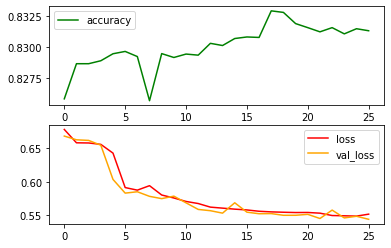

In [ ]:
plot_learning(history)

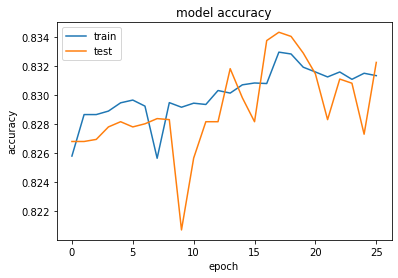

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results = model.evaluate(np.expand_dims(X_test_mitbih, axis=2), y_test_mitbih, batch_size=70)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

235/235 [==============================] - 12s 49ms/step - loss: 0.5667 - accuracy: 0.8251
The accuracy on the testing set is 82.5%


In [ ]:
y_pred_mitbih = model.predict(np.expand_dims(X_test_mitbih, axis=2))
y_pred_mitbih_bool = np.argmax(y_pred_mitbih, axis=1)
print(classification_report(y_test_mitbih, y_pred_mitbih_bool))

confusion_matrix = tf.math.confusion_matrix(y_test_mitbih, y_pred_mitbih_bool)
print(f"Confusion matrix :\n {confusion_matrix}")

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90     13526
         1.0       0.00      0.00      0.00       455
         2.0       0.51      0.04      0.08      1073
         3.0       0.00      0.00      0.00       147
         4.0       0.47      0.29      0.36      1216

    accuracy                           0.83     16417
   macro avg       0.36      0.26      0.27     16417
weighted avg       0.76      0.83      0.78     16417

Confusion matrix :
 [[13143     0    37     0   346]
 [  444     0     9     0     2]
 [  971     0    47     0    55]
 [  147     0     0     0     0]
 [  860     0     0     0   356]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


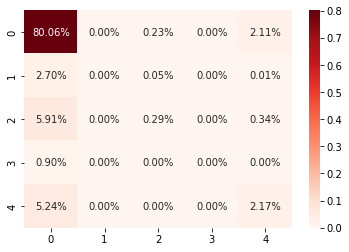

In [ ]:
import seaborn as sns
##sns.heatmap(confusion_matrix, annot=True)

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,
            fmt='.2%', cmap='Reds')